# Inclusion Stress Field Prediction

Импортируем библиотеки:

In [1]:
import os
import glob

import cv2

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import transforms, models
from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError

import albumentations as A

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
torch.manual_seed(42)
cudnn.deterministic = True
cudnn.benchmark = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Обозначим константы:

In [2]:
#Model Constants
IMAGE_SIZE = 256
BATCH_SIZE = 5
LAMBDA_L1 = 100
LEARNING_RATE = 1e-3
EPOCH = 300
MODEL_NAME = 'Pix2Pix'

Основные пути к папкам, откуда мы будем брать исходные данные для данного проекта:

In [3]:
path_folder = 'S:/abaqus_job_files/plot\\'
path_table = 'S:/abaqus_job_files/stresses_data/general_array.csv'
path_inclusions_count = 'S:/abaqus_job_files/stresses_data/inclusions.csv'
path_radius = 'S:/abaqus_job_files/stresses_data/radius_array.csv'
path_model_save = 'S:/abaqus_job_files/models/'

## Работа с табличными данными

In [4]:
def data_preparation(path=path_folder,
                     path_array=path_table,
                     path_incl=path_inclusions_count,
                     path_rad=path_radius):
    
    plots = ['mises', 'geom']
    
    #read data
    df = pd.read_csv(path_array, delimiter=' ', header=0).round(2)
    df['inclusions'] = pd.read_csv(path_incl, delimiter=' ', header=0).round(0).values
    df['radius'] = pd.read_csv(path_rad, delimiter=' ', header=0).values
    df['area'] = (np.pi * (df['radius']) ** 2) * df['inclusions']
    df.index += 1
    
    for i in plots:

        raw_images = sorted(glob.glob(path + '/*' + i + '*'), key=len)
        df['images_' + i] = raw_images
    
    #df = df.dropna(axis=1)
    df_train, df_valid = train_test_split(df,
                                          train_size=.8,
                                          random_state=42,
                                          shuffle=True)
    
    print(f'Train shape: {df_train.shape[0]}')
    print(f'Valid shape: {df_valid.shape[0]}')
        
    return df_train, df_valid

Разделим данные на тренировочную, валидационную и тестовую выборки.

In [5]:
df_train, df_valid = data_preparation()

Train shape: 800
Valid shape: 200


In [6]:
df_train.head()

,max_stress,min_stress,inclusions,radius,area,images_mises,images_geom
30,139.83,95.60,11.0,0.574,11.385873,S:/abaqus_job_files/plot\30_mises.png,S:/abaqus_job_files/plot\30_geom.png
536,164.12,87.17,24.0,0.742,41.511548,S:/abaqus_job_files/plot\536_mises.png,S:/abaqus_job_files/plot\536_geom.png
696,131.88,91.16,11.0,0.779,20.970920,S:/abaqus_job_files/plot\696_mises.png,S:/abaqus_job_files/plot\696_geom.png
558,158.98,91.71,20.0,0.610,23.379733,S:/abaqus_job_files/plot\558_mises.png,S:/abaqus_job_files/plot\558_geom.png
837,163.74,89.45,23.0,0.825,49.179669,S:/abaqus_job_files/plot\837_mises.png,S:/abaqus_job_files/plot\837_geom.png


## EDA

Оценим распределение представленных величин.

In [7]:
def kde_plot(data_list):
    
    columns = ['max_stress', 'min_stress']
    
    fig, ax = plt.subplots(1, 2, figsize=(13, 7))
    
    for data in data_list:
        for column, i in zip(columns, [0, 1]):
            
            sns.kdeplot(x=column,
                        data=data,
                        shade=True,
                        ax=ax[i])
            
            if i == 0:
                ax[i].set_ylabel('Density', fontsize=12)
            else:
                ax[i].set_ylabel('')
                
            ax[i].set_xlabel(f'{column}')
            ax[i].set_title(f'KDE of {column}')
            ax[i].legend(['Train', 'Valid'])
    
    fig.suptitle(f'Kernel density estimation of min and max stress variables', fontsize=18)
    fig.tight_layout()
    plt.show()

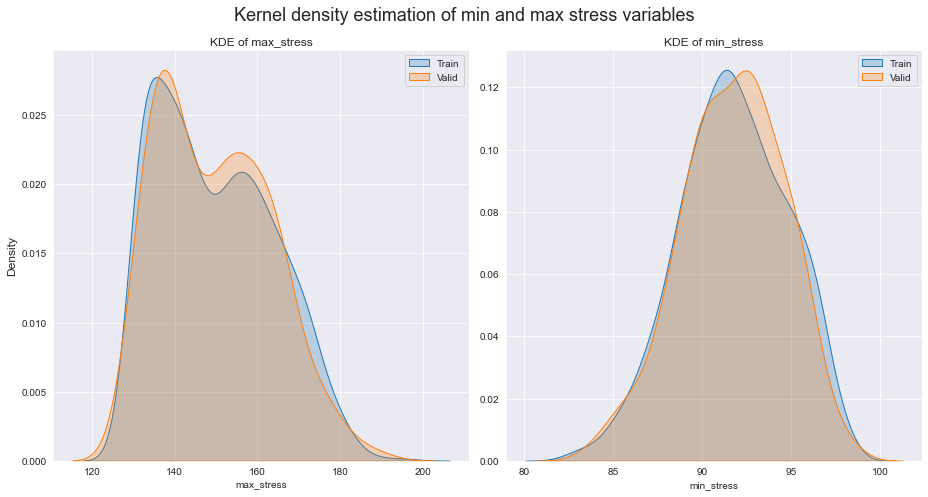

In [8]:
kde_plot([df_train, df_valid])

Распределения всех представленных величин крайне схожи по своей форме для различных наборов данных - тренировочного, валидационного и тестового датасетов.

## Загрузчик данных

Напишем загрузчик данных, который сможет выгружать датасеты по отдельным компонентам.

In [9]:
class StressDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        #geometry preprocessing
        geometry = cv2.imread(self.df.iloc[index, -1], cv2.IMREAD_GRAYSCALE)
        #crop
        geometry = geometry[20:780, 331:1092]
        #resize
        geometry = cv2.resize(geometry, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        #normalize
        #geometry = (255 - geometry)
        geometry = cv2.threshold(geometry, 127, 255, cv2.THRESH_BINARY)[1]
        geometry = geometry / 255
        #add additional dimension
        geometry = np.array([geometry]).astype('float32')
          
        result = cv2.imread(self.df.iloc[index, -2], cv2.IMREAD_GRAYSCALE)
        #crop
        result = result[118:637, 523:1043]
        #resize image
        result = cv2.resize(result, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        #normolize between 0 and 1
        result = result / 255
        
        #normalize between min and max stresses
        result = cv2.normalize(
            result, None, alpha=self.df.iloc[index, 1], beta=self.df.iloc[index, 0], norm_type=cv2.NORM_MINMAX
        )
        result = np.array([result]).astype('float32')
        
        #augmentation
        if self.transform is not None:
            aug = self.transform(image=result, mask=geometry)
            result = aug['image']
            geometry = aug['mask']
        
        #convert to torch.Tensor
        geometry = torch.from_numpy(geometry.copy()).type(torch.float32)
        result = torch.from_numpy(result.copy()).type(torch.float32)
        
        return (geometry, result)

In [10]:
train_transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1)
])

Начнем работу с компоненты тензора напряжений - $\bf{\sigma_{11}}$.

In [11]:
train_dataset = StressDataset(df_train, transform=train_transform)
valid_dataset = StressDataset(df_valid)

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
def image_show_tensor(dataloader, number_of_images=3, initial_index=0, values_name=None):
    
    masks, images = next(iter(dataloader))

    fig = plt.figure(figsize=(20, 20))
    
    for idx, tensor in enumerate([masks, images]):
        
        tensor = tensor.numpy().transpose(0,2,3,1)
        
        fig = plt.figure(figsize=(20, 20))
        
        for i in range(number_of_images):

            fig.add_subplot(1, number_of_images+1, i+1)
            
            min = (tensor[i+initial_index]).min()
            max = (tensor[i+initial_index]).max()
            
            if idx == 0:
                plt.imshow(tensor[i+initial_index], cmap='PuBu')
                plt.title(f'Geometry Inclusion={min:.0f}; Matrix={max:.0f}')
            else:
                plt.imshow(tensor[i+initial_index], cmap='icefire')
                plt.title(f'von Mises Stress Min={min:.2f}; Max={max:.2f}')

            plt.clim(min, max)
            plt.colorbar(shrink=0.2015)
            
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            
    plt.show()

<Figure size 1440x1440 with 0 Axes>

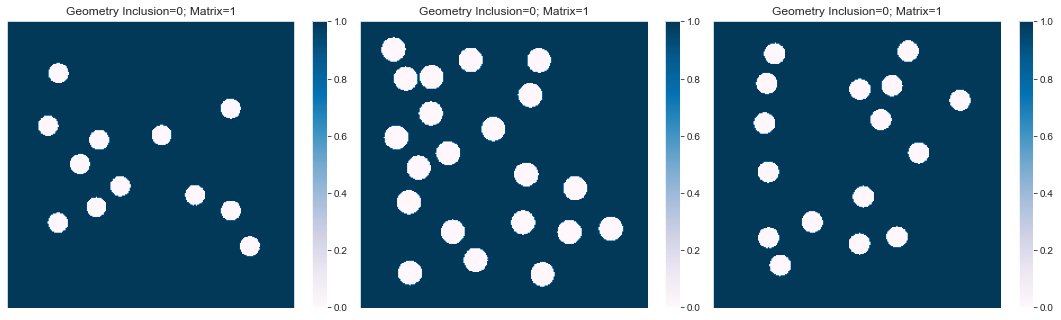

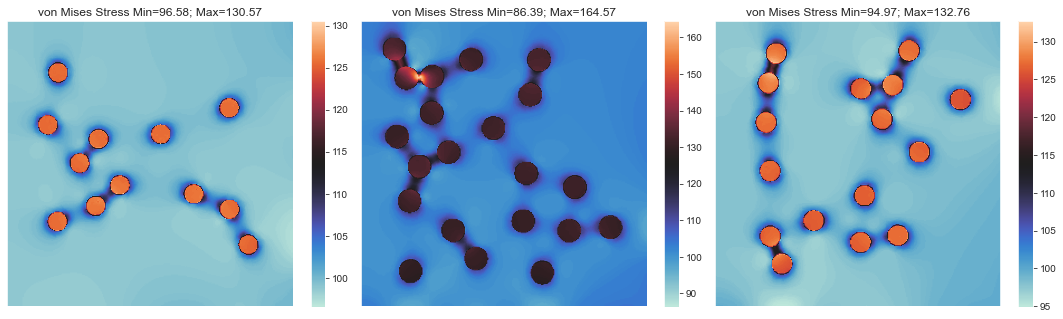

In [14]:
image_show_tensor(train_dataloader)

## Модель 

Определим **дискриминатор**.

In [15]:
class Discriminator(nn.Module):
    """Discriminator Network"""
    def __init__(self):
        super(Discriminator, self).__init__()

        self.in_channels = 1
        self.ndf = 64
        self.out_channels = 1

        self.main = nn.Sequential(
            nn.Conv2d(self.in_channels * 2, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 128

            nn.Conv2d(self.ndf, self.ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ndf*2),
            # 64 x 64

            nn.Conv2d(self.ndf*2, self.ndf*4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ndf*4),
            # 32 x 32

            nn.Conv2d(self.ndf*4, self.ndf*8, 4, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ndf*8),
            # 31 x 31

            nn.Conv2d(self.ndf*8, self.out_channels, 4, 1, 1, bias=False),
            # 30 x 30 (PatchGAN)
            nn.Sigmoid()
        )

    def forward(self, x, label):
        
        out = torch.cat((x, label), dim=1)
        out = self.main(out)
        
        return out

И **генератор**.

In [16]:
class Generator(nn.Module):
    """Generator Network"""
    def __init__(self):
        super(Generator, self).__init__()

        self.input_dim = 1
        self.ngf = 64
        self.output_dim = 1

        self.conv1 = nn.Sequential(
            nn.Conv2d(self.input_dim, self.ngf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.ngf, self.ngf*2, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(self.ngf*2, self.ngf*4, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*4)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(self.ngf*4, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )

        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )

        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )

        self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*4, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*4),
            nn.ReLU(inplace=True)
        )

        self.deconv6 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*8, self.ngf*2, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*2),
            nn.ReLU(inplace=True)
        )

        self.deconv7 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*4, self.ngf, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf),
            nn.ReLU(inplace=True)
        )

        self.deconv8 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*2, self.output_dim, 4, 2, 1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)

        dec1 = torch.cat([self.deconv1(enc8), enc7], dim=1)
        dec2 = torch.cat([self.deconv2(dec1), enc6], dim=1)
        dec3 = torch.cat([self.deconv3(dec2), enc5], dim=1)
        dec4 = torch.cat([self.deconv4(dec3), enc4], dim=1)
        dec5 = torch.cat([self.deconv5(dec4), enc3], dim=1)
        dec6 = torch.cat([self.deconv6(dec5), enc2], dim=1)
        dec7 = torch.cat([self.deconv7(dec6), enc1], dim=1)
        out = self.deconv8(dec7)

        return out

In [17]:
def set_requires_grad(network, requires_grad=False):
    """Prevent a Network from Updating"""
    for param in network.parameters():
        param.requires_grad = requires_grad

In [18]:
D = Discriminator().to(device)
G = Generator().to(device)

Обозначим дополнительные метрики оценки качества работы генератора:

In [19]:
mean_absolute_error = MeanAbsoluteError()
mean_squared_error = MeanSquaredError()

Определим **loss**-функцию и **optimizer**.

In [20]:
criterion_Adversarial = nn.BCELoss()
criterion_Pixelwise = nn.L1Loss()

In [21]:
D_optim = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
G_optim = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

## Обучение

In [22]:
G_train_loss_history, G_valid_loss_history = [], []
D_train_loss_history, D_valid_loss_history = [], []

mae_train_loss_history, mae_valid_loss_history = [], []
mse_train_loss_history, mse_valid_loss_history = [], []

for epoch in range(EPOCH):
    
    G_train_batch_loss_history, G_valid_batch_loss_history = [], []
    D_train_batch_loss_history, D_valid_batch_loss_history = [], []
    
    mae_train_batch_loss_history, mae_valid_batch_loss_history = [], []
    mse_train_batch_loss_history, mse_valid_batch_loss_history = [], []
    
    #train
    for geometry, result in train_dataloader:
        
        D_optim.zero_grad()
        G_optim.zero_grad()
        
        geometry = geometry.to(device, dtype=torch.float)
        result = result.to(device, dtype=torch.float)
        
        set_requires_grad(D, requires_grad=False)
        
        #Train Generator
        fake_result = G(geometry)
        prob_fake = D(fake_result, geometry)
        real_labels = torch.ones(prob_fake.size()).to(device)
        
        G_loss_fake = criterion_Adversarial(prob_fake, real_labels)
        G_loss_pixelwise = criterion_Pixelwise(fake_result, result)
        G_loss = G_loss_fake +  LAMBDA_L1 * G_loss_pixelwise
        mae_train = mean_absolute_error(fake_result.cpu(), result.cpu())
        mse_train = mean_squared_error(fake_result.cpu(), result.cpu())
        
        mae_train_batch_loss_history.append(mae_train.item())
        mse_train_batch_loss_history.append(mse_train.item())
        G_train_batch_loss_history.append(G_loss.item())
        
        G_loss.backward()
        G_optim.step()
        
        #Train Discriminator
        set_requires_grad(D, requires_grad=True)
        
        prob_real = D(result, geometry)
        real_labels = torch.ones(prob_real.size()).to(device)
        D_real_loss = criterion_Adversarial(prob_real, real_labels)
        
        fake_result = G(geometry)
        prob_fake = D(fake_result.detach(), geometry)
        fake_labels = torch.zeros(prob_fake.size()).to(device)
        
        D_fake_loss = criterion_Adversarial(prob_fake, fake_labels)
        D_loss = torch.mean(D_real_loss + D_fake_loss)
        D_train_batch_loss_history.append(D_loss.item())
        
        D_loss.backward()
        D_optim.step()
        
        del geometry, result, fake_labels, real_labels
        torch.cuda.empty_cache()
        
    #valid    
    for geometry, result in valid_dataloader:
        
        geometry = geometry.to(device, dtype=torch.float)
        result = result.to(device, dtype=torch.float)
        
        fake_result = G(geometry)
        prob_fake = D(fake_result, geometry)
        real_labels = torch.ones(prob_fake.size()).to(device)
        
        G_loss_fake = criterion_Adversarial(prob_fake, real_labels)
        G_loss_pixelwise = criterion_Pixelwise(fake_result, result)
        G_loss = G_loss_fake + LAMBDA_L1 * G_loss_pixelwise
        mae_valid = mean_absolute_error(fake_result.cpu(), result.cpu())
        mse_valid = mean_squared_error(fake_result.cpu(), result.cpu())
        
        mae_valid_batch_loss_history.append(mae_valid.item())
        mse_valid_batch_loss_history.append(mse_valid.item())
        G_valid_batch_loss_history.append(G_loss.item())
        
        prob_real = D(result, geometry)
        real_labels = torch.ones(prob_real.size()).to(device)
        D_real_loss = criterion_Adversarial(prob_real, real_labels)
        
        fake_result = G(geometry)
        prob_fake = D(fake_result.detach(), geometry)
        fake_labels = torch.zeros(prob_fake.size()).to(device)
        
        D_fake_loss = criterion_Adversarial(prob_fake, fake_labels)
        D_loss = torch.mean(D_real_loss + D_fake_loss)
        D_valid_batch_loss_history.append(D_loss.item())
        
        del geometry, result, fake_labels, real_labels
        torch.cuda.empty_cache()
    
    mae_train_loss = np.mean(mae_train_batch_loss_history)
    mae_train_loss_history.append(mae_train_loss)
    mse_train_loss = np.mean(mse_train_batch_loss_history)
    mse_train_loss_history.append(mse_train_loss)
    G_train_loss = np.mean(G_train_batch_loss_history)
    G_train_loss_history.append(G_train_loss)
    D_train_loss = np.mean(D_train_batch_loss_history)
    D_train_loss_history.append(D_train_loss)
    
    mae_valid_loss = np.mean(mae_valid_batch_loss_history)
    mae_valid_loss_history.append(mae_valid_loss)
    mse_valid_loss = np.mean(mse_valid_batch_loss_history)
    mse_valid_loss_history.append(mse_valid_loss)
    G_valid_loss = np.mean(G_valid_batch_loss_history)
    G_valid_loss_history.append(G_valid_loss)
    D_valid_loss = np.mean(D_valid_batch_loss_history)
    D_valid_loss_history.append(D_valid_loss)
    
    del G_train_batch_loss_history, D_train_batch_loss_history, G_valid_batch_loss_history, D_valid_batch_loss_history

    print(
        f'{epoch} | D:{D_train_loss:.4f} | G:{G_train_loss:.4f} | D Valid:{D_valid_loss:.4f} | G Valid:{G_valid_loss:.4f} | MAE:{mae_train_loss:.2f} | MSE:{mse_train_loss:.2f} | MAE Valid:{mae_valid_loss:.2f} | MSE Valid:{mse_valid_loss:.2f}'
    )

0 | D:0.3757 | G:4638.1323 | D Valid:0.0085 | G Valid:448.7543 | MAE:46.34 | MSE:3717.29 | MAE Valid:4.43 | MSE Valid:100.29
1 | D:0.2490 | G:413.5199 | D Valid:0.0034 | G Valid:342.3721 | MAE:4.08 | MSE:77.02 | MAE Valid:3.36 | MSE Valid:44.72
2 | D:0.0026 | G:311.5939 | D Valid:0.0018 | G Valid:281.7408 | MAE:3.05 | MSE:34.10 | MAE Valid:2.74 | MSE Valid:23.99
3 | D:3.1688 | G:255.3855 | D Valid:1.3555 | G Valid:268.4339 | MAE:2.53 | MSE:19.54 | MAE Valid:2.68 | MSE Valid:16.38
4 | D:1.3236 | G:222.8815 | D Valid:1.1585 | G Valid:209.6608 | MAE:2.22 | MSE:13.74 | MAE Valid:2.08 | MSE Valid:10.93
5 | D:1.1149 | G:212.5498 | D Valid:0.7665 | G Valid:198.9182 | MAE:2.11 | MSE:12.00 | MAE Valid:1.97 | MSE Valid:9.14
6 | D:0.7905 | G:200.6965 | D Valid:0.8012 | G Valid:203.6033 | MAE:1.99 | MSE:9.90 | MAE Valid:2.00 | MSE Valid:9.12
7 | D:0.5050 | G:197.9741 | D Valid:0.0948 | G Valid:202.6125 | MAE:1.95 | MSE:9.08 | MAE Valid:1.98 | MSE Valid:9.06
8 | D:0.9177 | G:188.9375 | D Valid:0.15

70 | D:0.6188 | G:69.1755 | D Valid:1.0104 | G Valid:208.7361 | MAE:0.66 | MSE:1.79 | MAE Valid:2.04 | MSE Valid:8.98
71 | D:0.5277 | G:68.1598 | D Valid:0.2694 | G Valid:184.2857 | MAE:0.65 | MSE:1.80 | MAE Valid:1.81 | MSE Valid:6.21
72 | D:0.6050 | G:67.1356 | D Valid:0.8607 | G Valid:181.5923 | MAE:0.64 | MSE:1.72 | MAE Valid:1.78 | MSE Valid:5.93
73 | D:0.5017 | G:67.8696 | D Valid:0.3469 | G Valid:186.2246 | MAE:0.64 | MSE:1.78 | MAE Valid:1.84 | MSE Valid:6.52
74 | D:0.5755 | G:70.7658 | D Valid:0.5066 | G Valid:184.1719 | MAE:0.67 | MSE:1.81 | MAE Valid:1.82 | MSE Valid:6.27
75 | D:0.5808 | G:67.7201 | D Valid:0.5510 | G Valid:189.8126 | MAE:0.64 | MSE:1.72 | MAE Valid:1.88 | MSE Valid:6.54
76 | D:0.6347 | G:67.9178 | D Valid:0.6944 | G Valid:190.0169 | MAE:0.65 | MSE:1.76 | MAE Valid:1.86 | MSE Valid:6.19
77 | D:0.5848 | G:65.9367 | D Valid:0.7323 | G Valid:188.6188 | MAE:0.63 | MSE:1.70 | MAE Valid:1.85 | MSE Valid:6.27
78 | D:0.6313 | G:65.4857 | D Valid:0.4251 | G Valid:183

140 | D:0.3402 | G:58.5789 | D Valid:4.2393 | G Valid:179.1205 | MAE:0.54 | MSE:1.36 | MAE Valid:1.74 | MSE Valid:5.67
141 | D:0.4135 | G:56.9164 | D Valid:3.8721 | G Valid:181.1242 | MAE:0.52 | MSE:1.34 | MAE Valid:1.77 | MSE Valid:5.88
142 | D:0.5950 | G:55.0752 | D Valid:3.0075 | G Valid:177.9252 | MAE:0.51 | MSE:1.30 | MAE Valid:1.74 | MSE Valid:5.71
143 | D:0.4318 | G:55.0037 | D Valid:4.5863 | G Valid:181.5413 | MAE:0.50 | MSE:1.32 | MAE Valid:1.76 | MSE Valid:5.75
144 | D:0.3422 | G:55.5762 | D Valid:3.4719 | G Valid:179.7536 | MAE:0.51 | MSE:1.31 | MAE Valid:1.76 | MSE Valid:5.80
145 | D:0.3112 | G:56.6054 | D Valid:3.1588 | G Valid:182.6648 | MAE:0.52 | MSE:1.32 | MAE Valid:1.79 | MSE Valid:5.99
146 | D:0.3737 | G:55.1197 | D Valid:3.8273 | G Valid:183.6078 | MAE:0.50 | MSE:1.29 | MAE Valid:1.79 | MSE Valid:5.98
147 | D:0.4632 | G:54.8540 | D Valid:3.0060 | G Valid:180.1190 | MAE:0.50 | MSE:1.30 | MAE Valid:1.77 | MSE Valid:5.85
148 | D:0.4297 | G:56.1303 | D Valid:4.3440 | G 

209 | D:0.3960 | G:52.8283 | D Valid:6.8706 | G Valid:189.3775 | MAE:0.47 | MSE:1.10 | MAE Valid:1.81 | MSE Valid:6.14
210 | D:0.4294 | G:51.0579 | D Valid:6.7633 | G Valid:185.9396 | MAE:0.46 | MSE:1.09 | MAE Valid:1.78 | MSE Valid:5.83
211 | D:0.4950 | G:50.7083 | D Valid:6.0163 | G Valid:183.5527 | MAE:0.45 | MSE:1.07 | MAE Valid:1.76 | MSE Valid:5.73
212 | D:0.5267 | G:51.1442 | D Valid:6.0429 | G Valid:184.9318 | MAE:0.46 | MSE:1.09 | MAE Valid:1.77 | MSE Valid:5.79
213 | D:0.4872 | G:50.4258 | D Valid:6.3090 | G Valid:195.3623 | MAE:0.45 | MSE:1.07 | MAE Valid:1.87 | MSE Valid:6.57
214 | D:0.4068 | G:51.1014 | D Valid:6.8487 | G Valid:187.6376 | MAE:0.46 | MSE:1.08 | MAE Valid:1.79 | MSE Valid:5.92
215 | D:0.3885 | G:52.8583 | D Valid:5.9371 | G Valid:185.2705 | MAE:0.47 | MSE:1.10 | MAE Valid:1.78 | MSE Valid:5.84
216 | D:0.4290 | G:51.1112 | D Valid:7.6277 | G Valid:186.0306 | MAE:0.46 | MSE:1.07 | MAE Valid:1.77 | MSE Valid:5.68
217 | D:0.4768 | G:51.5876 | D Valid:5.7090 | G 

278 | D:0.5317 | G:46.8819 | D Valid:6.0755 | G Valid:183.7763 | MAE:0.42 | MSE:0.94 | MAE Valid:1.76 | MSE Valid:5.68
279 | D:0.5866 | G:47.9136 | D Valid:4.6007 | G Valid:184.3388 | MAE:0.43 | MSE:0.95 | MAE Valid:1.78 | MSE Valid:5.87
280 | D:0.6046 | G:47.7890 | D Valid:5.9224 | G Valid:184.9290 | MAE:0.43 | MSE:0.95 | MAE Valid:1.77 | MSE Valid:5.84
281 | D:0.6086 | G:47.2378 | D Valid:6.3102 | G Valid:183.6779 | MAE:0.43 | MSE:0.93 | MAE Valid:1.76 | MSE Valid:5.56
282 | D:0.6016 | G:47.3459 | D Valid:7.0767 | G Valid:184.3904 | MAE:0.43 | MSE:0.93 | MAE Valid:1.75 | MSE Valid:5.65
283 | D:0.5870 | G:46.9325 | D Valid:6.6542 | G Valid:184.3473 | MAE:0.42 | MSE:0.92 | MAE Valid:1.76 | MSE Valid:5.68
284 | D:0.5671 | G:48.1524 | D Valid:5.5932 | G Valid:183.3003 | MAE:0.44 | MSE:0.95 | MAE Valid:1.76 | MSE Valid:5.75
285 | D:0.6045 | G:47.6957 | D Valid:5.5379 | G Valid:186.6813 | MAE:0.43 | MSE:0.93 | MAE Valid:1.79 | MSE Valid:5.75
286 | D:0.5518 | G:47.1346 | D Valid:6.0996 | G 

Сохраним полученную модель генератора.

In [23]:
torch.save(G, path_model_save + 'vonMises' + MODEL_NAME)

## Результаты 

Отдельно сохраним результаты обучения модели.

In [24]:
dict_data = {'G train loss' : G_train_loss_history,
             'G valid loss' : G_valid_loss_history,
             'D train loss' : D_train_loss_history,
             'D valid loss' : D_valid_loss_history,
             'MAE Train' : mae_train_loss_history,
             'MAE Valid' : mae_valid_loss_history,
             'MSE Train' : mse_train_loss_history,
             'MSE Valid' : mse_valid_loss_history}

In [25]:
df_results = pd.DataFrame.from_dict(dict_data)
df_results.to_csv('S:/abaqus_job_files/results_data/loss_results_vonMises_' + MODEL_NAME + '.csv', sep=' ')

In [26]:
def loss_plot(data):
    
    generator_loss_names = data.columns[:2]
    discriminator_loss_names = data.columns[2:]
    legend_names = ['Train', 'Valid']
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, j, k in zip(generator_loss_names, discriminator_loss_names, legend_names):
        
        ax[0].plot(data[i].values, label=k)
        ax[1].plot(data[j].values, label=k)
        
    for i, j in enumerate(['Generator', 'Discriminator']):

        ax[i].set_title(f'{j} Loss Plot', fontsize=14)
        ax[i].set_xlabel('Iteration', fontsize=12)
        ax[i].set_ylabel(f'{j} Loss Function Value', fontsize=12)
        ax[i].legend()
        
    fig.suptitle('Loss functions plot for von Mises', fontsize=18)
    plt.show()

Визуализируем значения функции потерь для каждого из датасетов.

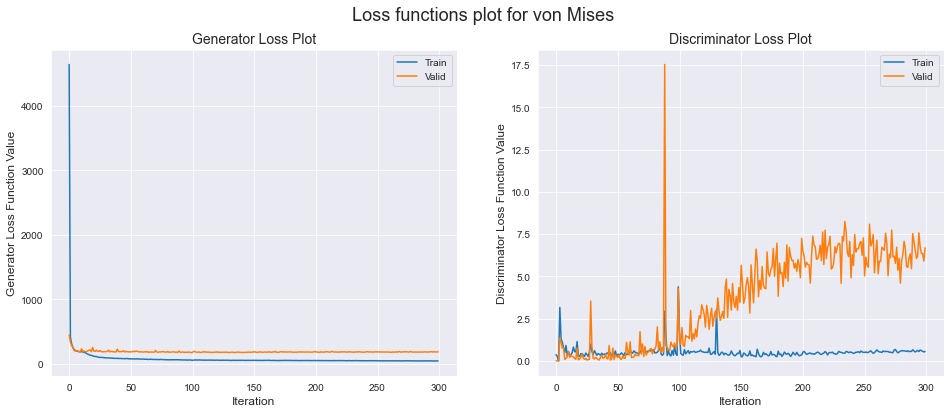

In [27]:
loss_plot(df_results)

Визуально оценим результаты работы алгоритма.

In [28]:
def singular_result(dataloader, model=G, initial_index=0, cmap='icefire', component='von Mises Stress'):
    
    model.eval()
    model = model.cpu()
    geometry, result = next(iter(dataloader))

    prediction = model(geometry.float())
    error = abs(result - prediction)

    tensors = [geometry, result, prediction, error]
    titles = ['Geometry', f'True {component} field', f'Predicted {component} field', '$L_{1}$ error']
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    
    for tensor, title, i, j in zip(tensors, titles, [0, 0, 1, 1], [0, 1, 0, 1]): 
        
        tensor = tensor.cpu().detach().numpy().transpose(0,2,3,1)
        
        if i == 0 and j == 0:
            img = ax[i, j].imshow(tensor[initial_index], cmap='PuBu')
        elif i != j:
            img = ax[i, j].imshow(tensor[initial_index], cmap=cmap)
        else:
            img = ax[i, j].imshow(tensor[initial_index], cmap='coolwarm')
            
        ax[i, j].set_title(title, fontsize=14)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
        min = (tensor[initial_index]).min()
        max = (tensor[initial_index]).max()
        
        if i == 1 and j == 1:
            img.set_clim(0, max)
        else:
            img.set_clim(min, max)
            
        plt.colorbar(img, shrink=0.815, ax=ax[i, j])
            
    fig.suptitle(f'Visualization for the one sample of {component}', fontsize=18)
    fig.tight_layout()
    plt.show()

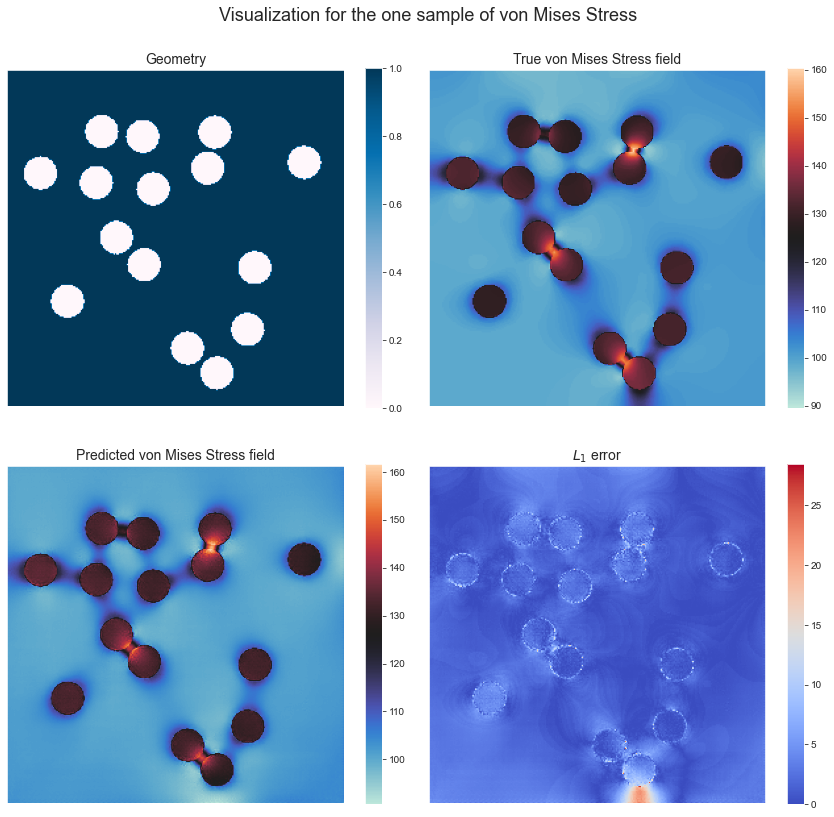

In [30]:
singular_result(valid_dataloader)